# Double-Bracket Iteration Strategy: Local Z search

In this example, we demonstrate the usage of the DBI strategy: local_Z_search, where the diagonal operator is chosen as the optimal local Z operator for the system.

In [10]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from hyperopt import hp, tpe

from qibo import hamiltonians, set_backend
from qibo.hamiltonians import Hamiltonian, SymbolicHamiltonian
from qibo.models.dbi.double_bracket import DoubleBracketGeneratorType, DoubleBracketIteration
from qibo.models.dbi.additional_double_bracket_functions import *
from qibo.symbols import I, X, Z
import warnings

## The initial setup

As an example, we consider the Transverse Field Ising Model (TFIM):
$$ H_{\rm TFIM} = - \sum_{q=0}^{N}\bigl( Z_i Z_{i+1} + h X_i \bigr),$$
which is already implemented in `Qibo`. For this tutorial we set $N=5$ and $h=3$.

[Qibo 0.2.3|INFO|2023-12-20 11:56:07]: Using qibojit (numba) backend on /CPU:0


Initial off diagonal norm 37.94733192202055


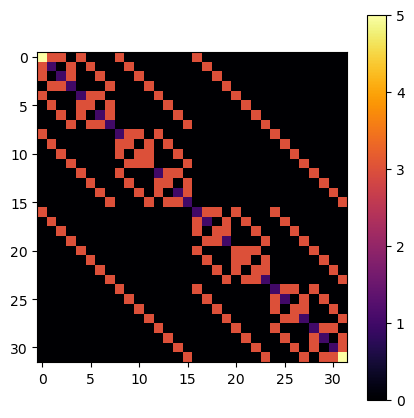

In [20]:
# set the qibo backend (we suggest qibojit if N >= 20)
# alternatives: tensorflow (not optimized), numpy (when CPU not supported by jit)
set_backend("qibojit", "numba")

# hamiltonian parameters
nqubits = 5
h = 3

# define the hamiltonian
h = hamiltonians.TFIM(nqubits=nqubits, h=h)

# initialize class
# Note: use deepcopy to prevent h being edited
dbi = DoubleBracketIteration(h,mode=DoubleBracketGeneratorType.single_commutator)
print("Initial off diagonal norm", dbi.off_diagonal_norm)
visualize_matrix(h.matrix)


## Local Z operators
Denoted as local Z operators, the diagonal operators used for this strategy are tensor products of pauli Z and identity.

In [12]:
generate_local_Z = generate_Z_operators(nqubits)
Z_ops = generate_local_Z["Z_operators"]
Z_names = generate_local_Z["Z_words"]

[Qibo 0.2.3|WARNING|2023-12-20 11:55:40]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.3|WARNING|2023-12-20 11:55:40]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.3|WARNING|2023-12-20 11:55:40]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.3|WARNING|2023-12-20 11:55:40]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.3|WARNING|2023-12-20 11:55:40]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.3|WARNING|2023-12-20 11:55:40]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.3|WARNING|2023-12-20 11:55:40]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.3|WARNING|2023-12-20 11:55:40]: Calculating the dens

In [21]:
# Verify the Z_ops are correct
# $\Delta(A) =\sum_{\mu\in\{0,1\}^{\times L} Z_\mu A Z_\mu$" we get $\|\Delta(A)  - A.diag()\| \le eps\|$.
dephasing_channel = (sum([Z_op @ h.matrix @ Z_op for Z_op in Z_ops]) + h.matrix)/2**nqubits
norm_diff = np.linalg.norm(dbi.diagonal_h_matrix - dephasing_channel)
print(norm_diff)

0.0


## Iteration from list

In [22]:
NSTEPS = 10
Z_optimal = []
off_diagonal_norm_history = [dbi.off_diagonal_norm]
steps = [0]
for _ in range(NSTEPS):
    idx, step = iteration_from_list(dbi, Z_ops, step_max=0.6)
    off_diagonal_norm_history.append(dbi.off_diagonal_norm)
    steps.append(step)
    if idx == len(Z_ops):
        Z_optimal.append("canonical")
    else:
        Z_optimal.append(Z_names[idx])
    print(f"New optimized step at iteration {_}/{NSTEPS}: {step} with operator {Z_optimal[-1]} norm {dbi.off_diagonal_norm}")

New optimized step at iteration 0/10: 0.22461177968747748 with operator ZZZZI norm 31.966734538297906
New optimized step at iteration 1/10: 0.03845265033885956 with operator ZIIIZ norm 27.755939593307335
New optimized step at iteration 2/10: 0.027099927986183554 with operator ZIIIZ norm 26.044733973096722
New optimized step at iteration 3/10: 0.05949237161426739 with operator IIIZZ norm 23.92910659572215
New optimized step at iteration 4/10: 0.0004024883635361719 with operator canonical norm 23.670167587947244
New optimized step at iteration 5/10: 0.03839567611025839 with operator IZIIZ norm 21.759377111077235
New optimized step at iteration 6/10: 0.05508708960922482 with operator IZIIZ norm 20.5315164700773
New optimized step at iteration 7/10: 0.026984254777118407 with operator IIIZZ norm 18.615202254486412
New optimized step at iteration 8/10: 0.093631252308069 with operator ZIZZI norm 15.114330234612124
New optimized step at iteration 9/10: 0.004424997817894337 with operator canoni

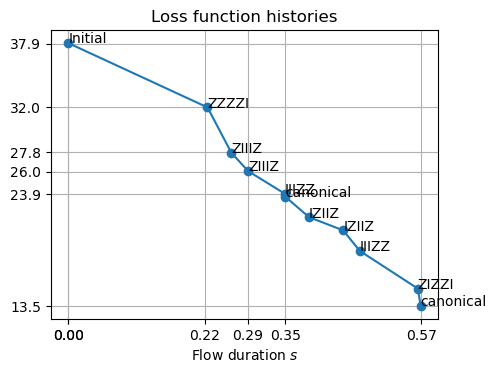

In [23]:
plot_histories(off_diagonal_norm_history, steps, Z_optimal)

## Compare with canonical

[Qibo 0.2.3|INFO|2023-12-20 11:33:27]: Using qibojit (numba) backend on /CPU:0


Initial off diagonal norm 37.94733192202055


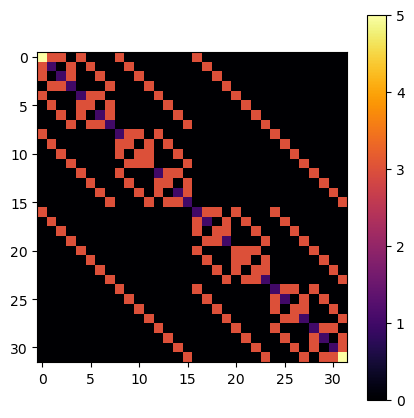

In [ ]:
# set the qibo backend (we suggest qibojit if N >= 20)
# alternatives: tensorflow (not optimized), numpy (when CPU not supported by jit)
set_backend("qibojit", "numba")

# hamiltonian parameters
nqubits = 5
h = 3

# define the hamiltonian
h = hamiltonians.TFIM(nqubits=nqubits, h=h)

# initialize class|
# Note: use deepcopy to prevent h being edited
dbi_canonical = DoubleBracketIteration(h,mode=DoubleBracketGeneratorType.canonical)
print("Initial off diagonal norm", dbi_canonical.off_diagonal_norm)
visualize_matrix(h.matrix)

In [ ]:
off_diagonal_norm_history = [dbi_canonical.off_diagonal_norm]
steps = [0]
for s in range(NSTEPS):
    if s != 0:
        step = dbi_canonical.hyperopt_step(
            step_min = 1e-5,
            step_max = 1,
            space = hp.uniform,
            optimizer = tpe,
            max_evals = 100,
        )
        print(f"New optimized step at iteration {s}/{NSTEPS}: {step}")
    dbi_canonical(step=step)
    off_diagonal_norm_history.append(dbi_canonical.off_diagonal_norm)
    steps.append(step)

New optimized step at iteration 1/10: 0.7062312186303615
New optimized step at iteration 2/10: 0.008532942926003376
New optimized step at iteration 3/10: 0.006606636973440978
New optimized step at iteration 4/10: 0.007800726979611531
New optimized step at iteration 5/10: 0.011122658550886365
New optimized step at iteration 6/10: 0.0067752987838349075
New optimized step at iteration 7/10: 0.00766267164940544
New optimized step at iteration 8/10: 0.0067358771941091475
New optimized step at iteration 9/10: 0.01048267830684162


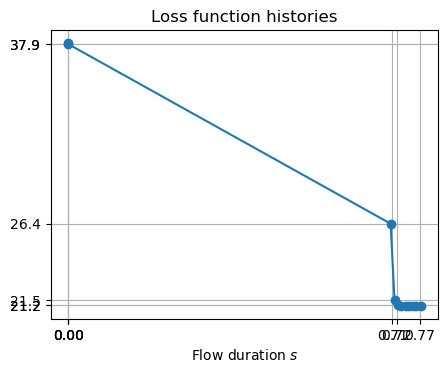

In [ ]:
plot_histories(off_diagonal_norm_history, steps)

Here we see that variationally chosen diagonal operators are less likely to converge to a local minimum compared to the GWW flow